# Atomic Scalability

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import argparse
from model.edieggc import EDiEGGC
from model.bgrl import BGRL
from tqdm import tqdm
import pickle

from data.data import QMugsTestDataloader

In [3]:
parser = argparse.ArgumentParser(description='dipole moment prediction training')
"""Experiment setting."""
parser.add_argument('--exp-name', type=str, default='qmugs_20_mmff_mu_g', help="")
parser.add_argument('--lacl', type=bool, default=True, help="True for training LACL, False for training")
parser.add_argument('--finetune', type=bool, default=False, help="")
parser.add_argument('--freeze', type=bool, default=False, help="")
parser.add_argument('--update_moving_average', type=bool, default=True, help="")
parser.add_argument('--loss', type=str, default='contrastive+prediction', help="")
parser.add_argument('--num-workers', type=int, default=6, help="")
parser.add_argument('--dataset', type=str, default='QMugs', help="data-chemical")
parser.add_argument('--set', type=str, default='src', help="'src' for source domain and 'tgt' for target domain")
parser.add_argument('--target', type=str, default='GFN2:TOTAL_FREE_ENERGY', help="homo, lumo, gap, mu, ...")
parser.add_argument('--geometry', type=str, default='MMFF', help="")
parser.add_argument('--epochs', type=int, default=300, help="")
parser.add_argument('--num-train', type=int, default=65000, help="110000/65000")
parser.add_argument('--num-valid', type=int, default=1500, help="10000/1500")
parser.add_argument('--num-test', type=int, default=1706, help="10829/1706")
parser.add_argument('--batch-size', type=int, default=32, help="")
parser.add_argument('--learning-rate', type=float, default=1e-3, help="")
parser.add_argument('--weight-decay', type=float, default=0, help="")
parser.add_argument('--max-norm', type=float, default=1000.0, help="")
parser.add_argument('--scheduler', type=str, default='plateau', help="")
parser.add_argument('--cutoff', type=float, default=4.0, help="")
parser.add_argument('--device', type=str, default='cuda', help="cuda device")
'''Model setting'''
parser.add_argument('--embedding-type', type=str, default='cgcnn', help="")
parser.add_argument('--alignn-layers', type=int, default=4, help="")
parser.add_argument('--gcn-layers', type=int, default=4, help="")
parser.add_argument('--atom-input-features', type=int, default=92, help="")
parser.add_argument('--edge-input-features', type=int, default=80, help="")
parser.add_argument('--triplet-input-features', type=int, default=40, help="")
parser.add_argument('--embedding-features', type=int, default=64, help="")
parser.add_argument('--hidden-features', type=int, default=256, help="")
parser.add_argument('--output-features', type=int, default=1, help="")
args = parser.parse_args([])

In [4]:
target_list = ['GFN2:DIPOLE', 'GFN2:HOMO_LUMO_GAP', 'GFN2:TOTAL_FREE_ENERGY']
checkpoint_list = {
    'GFN2:DIPOLE':[
        './ckpts/qmugs_20_mmff_mu_lacl',
        './ckpts/qmugs_20_mmff_mu_source_finetune',
    ],
    'GFN2:HOMO_LUMO_GAP':[
        './ckpts/qmugs_20_mmff_gap_lacl',
        './ckpts/qmugs_20_mmff_gap_source_finetune',
    ],
    'GFN2:TOTAL_FREE_ENERGY':[
        './ckpts/qmugs_20_mmff_fe_lacl',
        './ckpts/qmugs_20_mmff_fe_source_finetune',
    ],
}

In [14]:
test_maes_all = {}
for target in target_list:
    args.target = target
    test_maes_all[target] = {}
    for checkpoint in checkpoint_list[target]:
        typeofs = list(range(21, 40)) + ['ex']
        test_maes = []
        for typeof in typeofs:
            args.typeof = typeof
            test_loader = QMugsTestDataloader(args)
            if 'lacl' in checkpoint:
                args.lacl = True
                model = BGRL(args)
                model.load_state_dict(torch.load(checkpoint))
                model.to(args.device)
                model.eval()
                # inference
                labels = []
                pred1s = []
                pred2s = []
                for g1, lg1, g2, lg2, label in tqdm(test_loader):
                    g1 = g1.to(args.device)
                    lg1 = lg1.to(args.device)
                    g2 = g2.to(args.device)
                    lg2 = lg2.to(args.device)
                    label = label.to(args.device)
                    with torch.no_grad():
                        pred_1, pred_2, bgrl_loss, _, _, _, _ = model(g1, lg1, g2, lg2)
                    labels.append(label.detach().cpu().numpy())
                    pred1s.append(pred_1.detach().cpu().numpy())
                    pred2s.append(pred_2.detach().cpu().numpy())
                labels = np.hstack(labels)
                pred1s = np.hstack(pred1s)
                pred2s = np.hstack(pred2s)
            else:
                # Load model
                args.lacl = False
                model = EDiEGGC(args)
                model.load_state_dict(torch.load(checkpoint))
                model.to(args.device)
                model.eval()
                # inference
                labels = []
                pred1s = []
                pred2s = []
                loss = 0.0
                for g1, lg1, g2, lg2, label in tqdm(test_loader):
                    g1 = g1.to(args.device)
                    lg1 = lg1.to(args.device)
                    g2 = g2.to(args.device)
                    lg2 = lg2.to(args.device)
                    label = label.to(args.device)
                    with torch.no_grad():
                        pred1, _, _, _, _ = model(g1, lg1)
                        pred2 , _, _, _, _ = model(g2, lg2)
                    # loss += g1.batch_size * torch.nn.functional.l1_loss(pred, label).item()
                    labels.append(label.detach().cpu().numpy())
                    pred1s.append(pred1.detach().cpu().numpy())
                    pred2s.append(pred2.detach().cpu().numpy())
                labels = np.hstack(labels)
                pred1s = np.hstack(pred1s)
                pred2s = np.hstack(pred2s)
            test_maes.append([np.mean(np.abs(labels-pred1s)), np.mean(np.abs(labels-pred2s)), np.mean(np.abs(labels-np.mean(labels))), np.mean(labels)])
        test_maes_all[target][checkpoint] = test_maes


/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/numpy/lib/shape_base.py:790: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))
100%|██████████| 59/59 [00:13<00:00,  4.24it/s]
/home/yj/anaconda3/envs/scf/lib/python3.9/site-packages/numpy/lib/shape_base.py:790: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))
100%|██████████| 69/69 [00:16<00:00,  4.10it/s]
/home/yj/anaconda3/e

In [15]:
test_maes_mu_l = test_maes_all['GFN2:DIPOLE']['./ckpts/qmugs_20_mmff_mu_lacl']
test_maes_mu_s = test_maes_all['GFN2:DIPOLE']['./ckpts/qmugs_20_mmff_mu_source_finetune']
test_maes_gap_l = test_maes_all['GFN2:HOMO_LUMO_GAP']['./ckpts/qmugs_20_mmff_gap_lacl']
test_maes_gap_s = test_maes_all['GFN2:HOMO_LUMO_GAP']['./ckpts/qmugs_20_mmff_gap_source_finetune']
test_maes_fe_l = test_maes_all['GFN2:TOTAL_FREE_ENERGY']['./ckpts/qmugs_20_mmff_fe_lacl']
test_maes_fe_s = test_maes_all['GFN2:TOTAL_FREE_ENERGY']['./ckpts/qmugs_20_mmff_fe_source_finetune']

<class 'matplotlib.axes._subplots.AxesSubplot'>


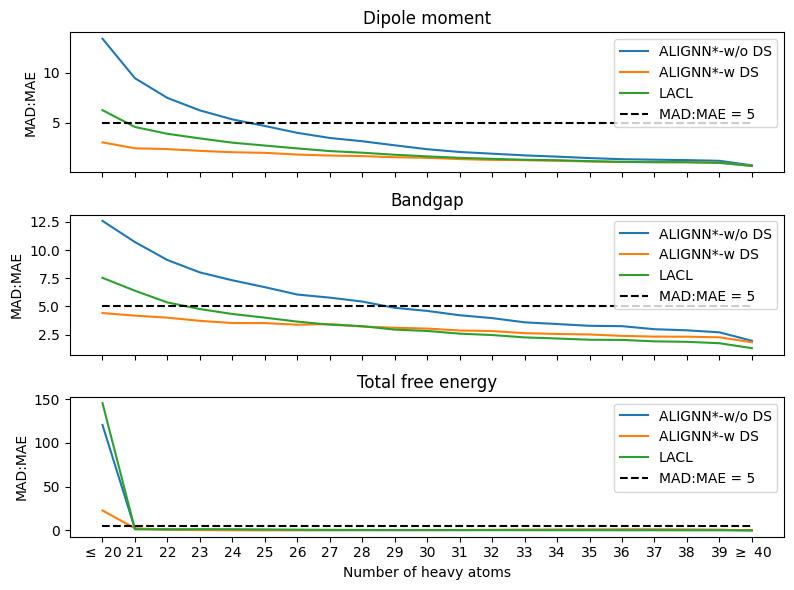

In [16]:
# 3 x 1 subplots
x_axis = [r'$\leq$ 20']+list(range(21,40))+[r'$\geq$ 40']
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
print(type(axes[0]))
# fig.suptitle('Scalability of ALIGNN', fontsize=16)
axes[0].plot(x_axis, 1.644/np.hstack([[0.12264], np.array(test_maes_mu_s)[:,0]]), label='ALIGNN*-w/o DS')
axes[0].plot(x_axis, 1.644/np.hstack([[0.54571], np.array(test_maes_mu_s)[:,1]]), label='ALIGNN*-w DS')
axes[0].plot(x_axis, 1.644/np.hstack([[0.2634], np.array(test_maes_mu_l)[:,1]]), label='LACL')
axes[0].plot([r'$\leq$ 20', r'$\geq$ 40'], [5,5], label='MAD:MAE = 5', c='black', linestyle='--')
axes[0].set_ylabel('MAD:MAE')
axes[0].set_title('Dipole moment')
axes[0].legend(loc='upper right')

axes[1].plot(x_axis, 23.28/np.hstack([[0.00185], np.array(test_maes_gap_s)[:,0]])/1000, label='ALIGNN*-w/o DS')#, color='orange')
axes[1].plot(x_axis, 23.28/np.hstack([[0.00528], np.array(test_maes_gap_s)[:,1]])/1000, label='ALIGNN*-w DS')#, color='orange')
axes[1].plot(x_axis, 23.28/np.hstack([[0.00309], np.array(test_maes_gap_l)[:,1]])/1000, label='LACL')#, color='orange')
axes[1].plot([r'$\leq$ 20', r'$\geq$ 40'], [5,5], label='MAD:MAE = 5', c='black', linestyle='--')
axes[1].set_ylabel('MAD:MAE')
axes[1].set_title('Bandgap')
axes[1].legend()

axes[2].plot(x_axis, 6028/np.hstack([[0.05007], np.array(test_maes_fe_s)[:,0]])/1000, label='ALIGNN*-w/o DS')#, color='green')
axes[2].plot(x_axis, 6028/np.hstack([[0.26481], np.array(test_maes_fe_s)[:,1]])/1000, label='ALIGNN*-w DS')#, color='green')
axes[2].plot(x_axis, 6028/np.hstack([[0.04147], np.array(test_maes_fe_l)[:,1]])/1000, label='LACL')#, color='green')
axes[2].plot([r'$\leq$ 20', r'$\geq$ 40'], [5,5], label='MAD:MAE = 5', c='black', linestyle='--')
axes[2].set_ylabel('MAD:MAE')
axes[2].set_title('Total free energy')
axes[2].legend()
plt.xlabel('Number of heavy atoms')
plt.tight_layout()